##Average Nowcast Currents by Wind Regime

In [2]:
from salishsea_tools import viz_tools, geo_tools, nc_tools
import numpy as np
import datetime
import dateutil.parser as parser
import xarray as xr
import matplotlib.pyplot as plt
import os
import netCDF4 as nc

%matplotlib inline

First load grid and mask files

In [3]:
# Load grid and mask files
mask_NEMO = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DMeshMask2V1')
grid_NEMO = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetry2V1')
grid_GEM  = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')

Make a GEM mask for SOG by comparing lon/lat pairs between GEM and NEMO

In [4]:
# Make GEM mask array
gridY, gridX = grid_GEM.longitude.shape
mask_array = np.zeros((gridY * gridX))

# Evaluate each point on GEM grid
for index, coords in enumerate(zip(
    grid_GEM.longitude.stack(z=('gridX', 'gridY')).values - 360,
    grid_GEM.latitude.stack(z=('gridX', 'gridY')).values)):
    
    j, i = geo_tools.find_closest_model_point(coords[0], coords[1], grid_NEMO.longitude, grid_NEMO.latitude)
    if j is np.nan or i is np.nan:
        mask_array[index] = 0
    else:
        mask_array[index] = mask_NEMO.tmask.isel(gridZ=0, gridX=i, gridY=j).values

# Reshape
mask_array = mask_array.reshape((gridY, gridX), order='F')

# Mask out PS and JdF
mask_array[200:, :] = 0
mask_array[:110, :] = 0
mask_array[:140, :125] = 0

# Convert to xarray
mask_GEM = xr.DataArray(mask_array, coords=[grid_GEM.gridY, grid_GEM.gridX], dims=['gridY', 'gridX'])

(270000, 500000)

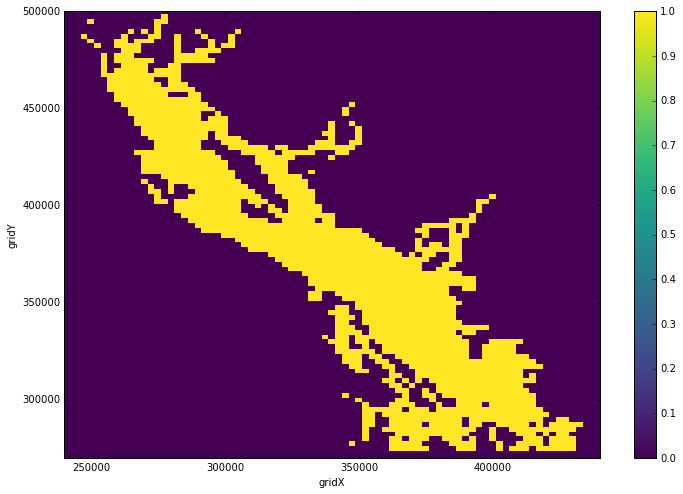

In [5]:
# Plot Mask
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
mask_GEM.plot(ax=ax)
ax.set_xlim([240000, 440000])
ax.set_ylim([270000, 500000])

Specify time range for analysis

In [8]:
# Timerange for analysis
timerange = ['2016 Sep 1 00:00', '2016 Oct 15 23:00']

Load Nowcast Green results

In [9]:
# Load nowcast-green results
filenames_U = nc_tools.make_filename_list(timerange, 'U', model='nowcast-green', resolution='d')
filenames_V = nc_tools.make_filename_list(timerange, 'V', model='nowcast-green', resolution='d')
filenames_T = nc_tools.make_filename_list(timerange, 'T', model='nowcast-green', resolution='d')
u_obj = xr.open_mfdataset(filenames_U).isel(depthu=0).resample('D', dim='time_counter', how='mean')
v_obj = xr.open_mfdataset(filenames_V).isel(depthv=0).resample('D', dim='time_counter', how='mean')
t_obj = xr.open_mfdataset(filenames_T).isel(deptht=0).resample('D', dim='time_counter', how='mean')
u = viz_tools.unstagger_xarray(u_obj.vozocrtx, 'x')[:, ::5, ::5]
v = viz_tools.unstagger_xarray(v_obj.vomecrty, 'y')[:, ::5, ::5]
u, v = viz_tools.rotate_vel(u, v)

Load GEM forcing

In [11]:
# Load GEM forcing
GEM = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
GEM = GEM.sel(time=slice(timerange[0], timerange[1])).resample('D', dim='time', how='mean').where(mask_GEM)
u_wind, v_wind = viz_tools.rotate_vel(GEM.u_wind, GEM.v_wind, origin='map')

Make wind timeseries average over SOG

In [12]:
# Make wind timeseries average over SOG
v_wind_TS = v_wind.mean(dim=('gridX', 'gridY')).rename({'time': 'time_counter'})

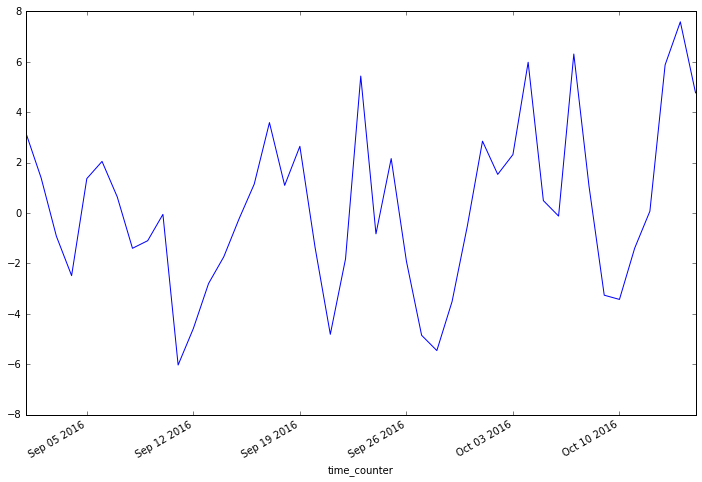

In [13]:
# Plot wind timeseries
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
v_wind_TS.plot()

In [22]:
u3 = u.where(v_wind_TS > 3).mean(dim='time_counter')
v3 = v.where(v_wind_TS > 3).mean(dim='time_counter')

/home/bmoorema/anaconda3/lib/python3.5/site-packages/dask/array/numpy_compat.py:44: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


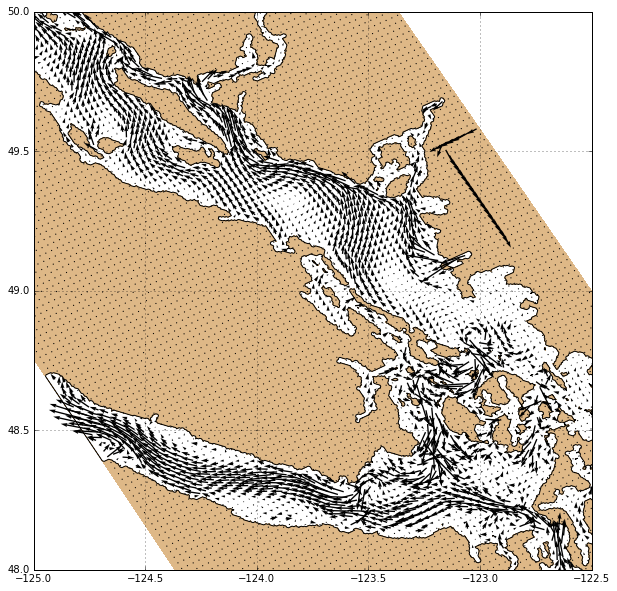

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

window=[-125, -122.5, 48, 50]
ax.set_xlim(window[0:2])
ax.set_ylim(window[2:4])
ax.grid()

ax.contourf(t_obj.nav_lon, t_obj.nav_lat, mask_NEMO.tmask.isel(time=0, gridZ=0), [-0.01, 0.01], colors='burlywood')
ax.contour(t_obj.nav_lon, t_obj.nav_lat, mask_NEMO.tmask.isel(time=0, gridZ=0), [0], colors='k')
ax.quiver(t_obj.nav_lon[::5, ::5], t_obj.nav_lat[::5, ::5], u3, v3, scale=10)

In [25]:
u_3 = u.where(v_wind_TS < 3).mean(dim='time_counter')
v_3 = v.where(v_wind_TS < 3).mean(dim='time_counter')

/home/bmoorema/anaconda3/lib/python3.5/site-packages/dask/array/numpy_compat.py:44: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


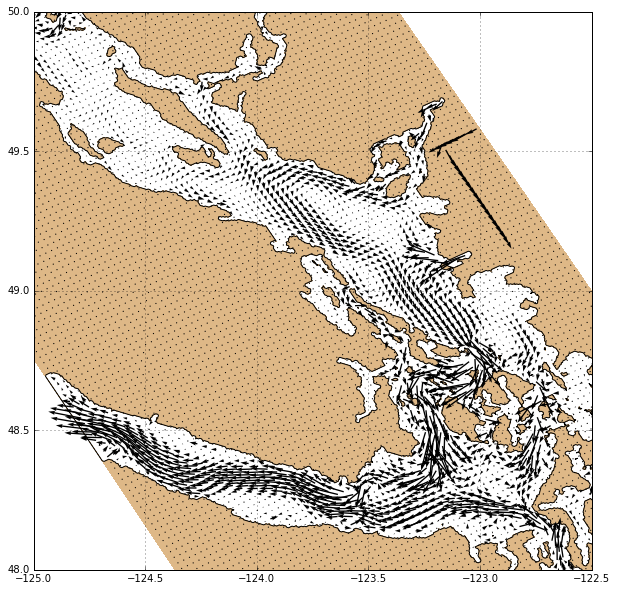

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

window=[-125, -122.5, 48, 50]
ax.set_xlim(window[0:2])
ax.set_ylim(window[2:4])
ax.grid()

ax.contourf(t_obj.nav_lon, t_obj.nav_lat, mask_NEMO.tmask.isel(time=0, gridZ=0), [-0.01, 0.01], colors='burlywood')
ax.contour(t_obj.nav_lon, t_obj.nav_lat, mask_NEMO.tmask.isel(time=0, gridZ=0), [0], colors='k')
ax.quiver(t_obj.nav_lon[::5, ::5], t_obj.nav_lat[::5, ::5], u_3, v_3, scale=10)